# 何をやったか

非負行列分解を、擬似2次交互射影勾配降下法で最適化しました。  
最適化アルゴリズムをnumpyで書いて、scikit-learnの挙動と概ね一致することを確かめました。  
トピックモデルとしての行列分解を整理し、性能を確かめるために、livedoorのニュースコーパスを使用しました。  
記事群から元の記事カテゴリを復元しました。

# きっかけ

行列分解の基本的なアルゴリズムを理解するために、MLPの「関係データ学習」を読んでいます。  
非負な行列の行列分解はトピックモデルと等価と書いてありました。トピックモデルは元々確率分布を仮定して解くやり方しか知らなかったので、一度整理して実装してみることにしました。  
「擬似2次交互射影勾配降下法」という最適化手法を使います。名前が厳つくてカッコいいです。

# 行列分解

## 行列分解とは

既知の$I$行$J$列の行列$X$、未知の$I$行$R$列の行列$U$、$J$行$R$列の行列$V$があるとします。  
行列分解とは
$$
X \simeq UV^T
$$
とXをU, Vで近似する手法です。  
Xの値が全て0以上の場合は、非負行列分解となります。  

## トピック抽出との関連
文章$i$、単語$j$、文章のトピック数を$r$、文章$i$で単語$j$が出現する回数を$z_{i,j}$とします。これらを並べた$(i,j)$行列$Z$を定義し、
$$
X = \frac{1}{\sum_i \sum_j z_{i.j}} Z
$$
とします。  
行列$X$は全ての値が非負な行列となり、各成分の総和が1となるので、$X$は確率と見なせます。この$X$に対して行列分解を行うと、$U$の値$u_{i,r}$は文章$i$がトピック$r$に属する度合い、$V$の値$v_{j,r}$は単語$j$がトピック$r$に属する度合いと解釈出来ます。

# 勾配法による最適化

## 損失関数の定義
まず、近似した行列$UV^T$が$X$にどれくらい近づいているか、損失関数を定義します。l2正則化付き二乗誤差を使用します。
$$
f_l = \frac{1}{2}\|X - UV^T\|_{Fro}^{2}+\frac{\lambda}{2}\left(\|U\|_{Fro}^2 + \|V\|_{Fro}^2\right)
$$
Froとはフロベニウスのノルムの事で、この場合は要素毎に二乗した全ての値を足し合わせます。正則化とは、$U$や$V$が過学習する(=訓練データに過剰に適合するため個々の要素の大きさが大きくなる)事を防ぐ働きがあります。  

## 最適化手法
次に、最適化手法を決めます。Newton法を用います。  
例えば、ある関数$g(\mathbf{\theta})$を最小化する値$\theta^*$を求めたい場合、学習率を$\eta$とおくと、
$$
\theta^{new} =\theta^{old} - \eta \left(\nabla \nabla^T g(\theta^{old})\right)^{-1} \nabla g(\theta^{old})
$$
を反復し、$\|\theta^{new} - \theta^{old}\|_{Fro}$が一定値より小さくなったときの値$\theta^{new}$を返すアルゴリズムです。

上の式は、テイラー展開から導出されます。パラメータが1つの場合を考えます。    
$g(\theta)$をある値$\bar{\theta}$の周りで2次のテイラー展開をして、3次以上を無視すると以下のようになります。
$$
g(\overline{\theta}+\Delta\theta) = g(\overline{\theta}) + g'(\overline{\theta})\Delta\theta + \frac{1}{2} g''(\overline{\theta}) \Delta\theta^2
$$
$g(\theta)$の形は複雑なので、直接極小点$\theta^*$を計算する事は難しいです。しかし、$\theta^*$の近くの適当な値$\overline{\theta}$における$g(\overline{\theta})$を2次式で近似し、$\theta$で微分する事で近似式の極小点$\theta^{new}$を求めると、元の点$\overline{\theta}$よりかは真の極小点$\theta^*$に近づいているはずです。この作業を繰り返せば、いつか元の$g(x)$の極小点に辿り着くだろうというのがニュートン法の基本的な発想です。  
$\theta$で微分する事と$\Delta \theta=\theta - \overline{\theta}$で微分する事は等価(連鎖率で検索)なので、$g(\overline{\theta}+\Delta\theta)$を$\Delta\theta$についての式とみて、この2次近似式が極値、つまり勾配が0になるような$\Delta\theta$を求めます。上式の右辺を微分し0を代入すると、
$$
g'(\overline{\theta}) + g''(\overline{\theta})\Delta \theta = 0 \\
\Delta \theta = - \frac{g'(\overline{\theta})}{g''(\overline{\theta})}
$$
となります。$\Delta \theta=\theta - \overline{\theta}$なので、更新された$\theta$の値は
$$
\theta^{new} = \overline{\theta} - \frac{g'(\overline{\theta})}{g''(\overline{\theta})}
$$
となります。この式に学習率$\eta$を掛けたものが1変数の場合のNewton法の更新式になります。
$$
\theta^{new} = \overline{\theta} - \eta \frac{g'(\overline{\theta})}{g''(\overline{\theta})}
$$
これを多変量に拡張すると初めに書いた式になります。

$\theta^{new}$が$\theta^*$に十分に近付いた場合、$\theta$の更新量$\Delta \theta$は小さくなるはずです。$\|\Delta \theta\|_{Fro}$が一定の値を下回ればパラメータの更新を終了します。

Newton法をベクトルや行列に拡張する場合、$\Delta\theta$の分母を計算するためにはヘッセ行列の逆行列を計算する必要があります。今回の損失関数$f_{l}$のパラメータは2つの行列$U, V$で、Uの2階微分,UとVの微分, Vの2階微分を計算するので、ヘッセ行列全体の大きさは$(I+J)R×(I+J)R$となります。逆行列を計算するためには大体辺の長さの3乗の計算コストがかかるため、計算コストが膨大になってしまいます。そこで、ヘッセ行列の$\nabla_{U}\nabla_{U}, \nabla_{V}\nabla_{V}$成分以外を0とすると、ヘッセ行列はブロック対角行列になるので、ブロック毎に逆行列を計算すればよくなり、計算量が大幅に減ります。  
多分この近似が"擬似"の由来になってます。  

最終的なパラメータの更新式は以下のようになります。UとVを交互に更新します。

$$
U^{new} = (1-\eta)U + \eta XV(V^TV+\lambda I)^{-1} \\
V^{new} = (1-\eta)V + \eta X^{T}U(U^TU+\lambda I)^{-1} 
$$

U, Vは非負の行列なので、更新時に負の値を取った要素は0に置換します。

# 実装

livedoor ニュースコーパスを用います。9種類のニュースを元に文章集合を作って、トピック数9とした時に元のトピックをどこまで復元出来るか試してみます。  
https://www.rondhuit.com/download.html#ldcc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import MeCab
from pathlib import Path
import re

In [3]:
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'IPAPGothic'
%matplotlib inline

In [4]:
cat_path = Path('../input/text/')
cat_dir = [p for p in cat_path.iterdir() if p.is_dir()]

In [6]:
news_path = [[p for p in cat.iterdir()] for cat in cat_dir]

In [8]:
for dir_, cat in zip(cat_dir, news_path):
    print(len(cat), dir_)

871 ../input/text/movie-enter
871 ../input/text/it-life-hack
865 ../input/text/kaden-channel
771 ../input/text/topic-news
512 ../input/text/livedoor-homme
843 ../input/text/peachy
901 ../input/text/sports-watch
871 ../input/text/dokujo-tsushin
871 ../input/text/smax


ニュースのカテゴリと記事数は上のようになっています。  

livedoor ニュースコーパスはだいたい500~900記事/カテゴリのデータセットです。  
100記事/カテゴリを選択します。

In [9]:
path_select = []
for cat in news_path:
    path_select.extend(cat[:100])

In [10]:
text_select = []
for p in path_select:
    with open(p, mode='r') as f:
        text = f.read()
        text_select.append(text)

# 前処理

https://qiita.com/Hironsan/items/2466fe0f344115aff177  
https://github.com/Hironsan/natural-language-preprocessings/blob/master/preprocessings/ja/cleaning.py  
を参考にしました。  

クリーニング→正規化(半角→全角、数字、表記揺れ)→ストップワードの除去  

ストップワードは、出現数上位1%もしくは文章全体で出現頻度が10未満の単語とします。

In [11]:
from joblib import Parallel, delayed
from cleaning import clean_text
from normalization import normalize
from tokenizer import MeCabTokenizer
from collections import defaultdict, Counter

In [12]:
tokenizer_neologd = MeCabTokenizer('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')

In [13]:
def with_preprocess(text):
    text = clean_text(text)
    words = tokenizer_neologd.wakati_baseform(text)
    words = [normalize(word)  for word in words]
    return words

In [14]:
%%time
news_words = Parallel(n_jobs=-1)([delayed(with_preprocess)(text) for text in text_select])

CPU times: user 200 ms, sys: 54.8 ms, total: 254 ms
Wall time: 3.83 s


In [15]:
def get_stop_words(news_words, n=100, min_freq=1):
    c = Counter()
    for words in news_words:
        for word in words:
            c[word] += 1
    top_words = {word for word, _ in c.most_common(n)}
    rare_words = {word for word, freq in c.items() if freq < min_freq}
    stopwords = top_words | rare_words
    print('{}/{}'.format(len(stopwords), len(c)))
    return stopwords

In [16]:
stopwords = get_stop_words(news_words, n=100, min_freq=10)

25444/29837


In [39]:
# stopwordsの削除
for i in range(len(news_words)):
    news_words[i] = [w for w in news_words[i] if w not in stopwords]

大体4000単語が残りました。

# 文章と単語のクラス作成

In [40]:
class Vocab:
    def __init__(self):
        self.word2index = defaultdict(int)
        self.word2count = defaultdict(int)
        self.index2word = defaultdict(str)
        self.n_words = 0
    def add_text(self, text):
        for word in text.split(" "):
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [41]:
vocab = Vocab()

In [42]:
%%time
for words in news_words:
    for word in words:
        if word not in stopwords:
            vocab.add_word(word)

CPU times: user 102 ms, sys: 3.43 ms, total: 105 ms
Wall time: 103 ms


In [43]:
vocab.n_words

4393

In [44]:
class News:
    def __init__(self):
        self.index2title = defaultdict(str)
        self.index2words = defaultdict(list)
        self.index2text = defaultdict(str)
        self.n_news = 0
    
    def add_news(self, news_titles, news_words):
        for title, words in zip(news_titles, news_words):
            self.index2title[self.n_news] = title
            self.index2words[self.n_news] = words
            self.index2text[self.n_news] = "".join(words)
            self.n_news += 1

In [45]:
news = News()

In [46]:
news_titles = [text.split("\n")[2] for text in text_select]

In [47]:
news.add_news(news_titles, news_words)

In [48]:
news.n_news

900

# 記事×単語の行列作成

単純に文章毎に単語の出現頻度をカウントするより、予め文章内総単語に占める個々の単語の割合を計算して、文章内にその単語が現れたら割合値を代入するやり方にした方が、行列分解がいい感じに出来ました。

In [49]:
all_words_count = sum([i for i in vocab.word2count.values()])

In [50]:
## 参考書通りの実装
## 一部のクラスターに集中する
X = np.zeros((news.n_news, vocab.n_words))
for i in range(news.n_news):
    for word in news.index2words[i]:
            word_idx = vocab.word2index[word]
            X[i, word_idx] += 1
X = X / all_words_count

In [51]:
# 単語の出現頻度を計算して総出現単語数で割っているので、Xの合計値は1になる
# よって、Xは文章と単語の同時出現確率と解釈できる
X.sum()

1.0

In [52]:
X = np.zeros((news.n_news, vocab.n_words))
for i in range(news.n_news):
    for word in news.index2words[i]:
            p_word = vocab.word2count[word] / all_words_count
            idx_word = vocab.word2index[word]
            X[i, idx_word] = p_word

In [53]:
# 単純に同時確率を代入している訳ではないので、合計値は1ではなくなる
# 確率ではない
X.sum()

62.213990106839226

In [54]:
np.where(X != 0)[0].shape[0] / (900 * 4393)

0.027761590408983988

Xは非0の割合が3%弱の非常に疎な行列です

# scikit-learnで動作確認

準備したデータセットで本質的に行列分解が上手くいくのかを確かめるために、予めscikit-learnで挙動を確かめておきます。

In [55]:
from sklearn.decomposition import NMF

In [56]:
model = NMF(9, alpha=0.01, random_state=1234) # alpha: l2正則化の割合

In [57]:
U = model.fit_transform(X)

In [58]:
V = model.components_.T

学習が上手くいっているか確認します。  
Xは各トピックから100記事を選んで結合した行列なので、100行毎に関連度の最も高いトピックを見てみます。

In [60]:
news_cluster = np.empty((9, 9))
for i in range(9):
    uc = U[i*100:(i+1)*100, :]
    cl = uc.argmax(axis=1)
    for c in range(9):
        news_cluster[i, c] = Counter(cl)[c]

In [63]:
# 100行毎のニュースカテゴリ
for i in range(9):
    print('行{}: カテゴリ{}'.format(i, cat_dir[i]))

行0: カテゴリ../input/text/movie-enter
行1: カテゴリ../input/text/it-life-hack
行2: カテゴリ../input/text/kaden-channel
行3: カテゴリ../input/text/topic-news
行4: カテゴリ../input/text/livedoor-homme
行5: カテゴリ../input/text/peachy
行6: カテゴリ../input/text/sports-watch
行7: カテゴリ../input/text/dokujo-tsushin
行8: カテゴリ../input/text/smax


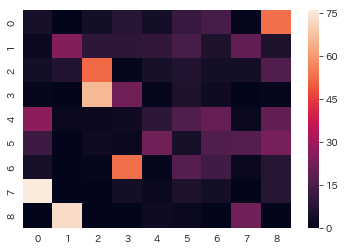

In [62]:
fig, ax = plt.subplots()
sns.heatmap(news_cluster)
plt.show()

行(ニュースのカテゴリ)毎に、異なるトピックに分類されている事がわかります。  
特に、カテゴリ7(dokujo-tsushin)とカテゴリ8(smax, iPhone関連の記事?)が鮮明に分かれています。

最後に、トピック毎にそのトピックに所属する割合が最も高い単語を確認します。

In [66]:
for i in range(9):
    top_word_idx = V[:,i].argsort()[::-1][:20]
    print("topic {}".format(i))
    print(" ".join([vocab.index2word[w] for w in top_word_idx]))

topic 0
0歳 いい くれる 今 私 方 そんな 仕事 けど し かも 何 気 聞く 男性 どう さ とき 持つ 考える
topic 1
対応 twitter smartphone max 利用 搭載 エスマックス 画面 場合 可能 サービス 発売 関連リンク 発表 約 情報 表示 アプリ on 執筆
topic 2
関連 情報 声 日本 おる 発表 twitter ユーザー ネット掲示板 な チェック 氏 いい 今 0月 てる どう 対応 発売 問題
topic 3
てる な けど について いい し やる 氏 じゃ 日本 何 とか 持つ 語る 声 どう 紹介 上 ところ コメント
topic 4
場合 について 方 くださる 必要 ※ 名 上 おる 利用 発表 情報 プレゼント いただく 数 様 本 応募 時間 キャンペーン
topic 5
行う について 公開 くれる 0月 行く 日本 による 利用 前 以上 てる サービス おる 今 者 必要 可能 語る 現在
topic 6
ぬ 何 紹介 さ 持つ 知る そして 前 今 おる ほど 必要 ところ そんな 仕事 ながら 感じる 考える しかし かも
topic 7
紹介 アプリ 以上 名 利用 方 android チェック 画面 iphone くださる 登場 とき そんな 人気 twitter かも 知る 表示 気
topic 8
さ 日本 そんな 登場 公開 発売 持つ 名 大 世界 発表 0月 くれる & 人気 たち さらに 約 今 0人


トピック0=カテゴリ7=dokujo-tsushin  
トピック1=カテゴリ8=smax  
なので、主要なカテゴリが上手くトピックとして復元出来ています。  
ただ、全てのカテゴリがトピックとして復元出来る訳ではありません。

# 行列を分解する

本題に入ります。  
擬似2次交互射影勾配降下法を書いてみます。

In [67]:
class MD:
    def __init__(self, r, alpha=0, lr=0.1, eps=0.0001, max_iter=200):
        self.r = r
        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.max_iter = max_iter
    
    def l2_loss(self, X, U, V):
        return ((X - np.dot(U, V.T))**2).sum() / 2 + ((U**2).sum() + (V**2).sum()) * self.alpha / 2
    
    
    def decompose(self, X):
        xi, xj = X.shape
        U = abs(np.random.rand(xi, self.r))
        V = abs(np.random.rand(xj, self.r))
        
        cnt = 0
        while True:
            cnt += 1
            g = self.l2_loss(X, U, V)
            U = (1 - self.lr) * U + self.lr * np.dot(np.dot(X, V), np.linalg.inv(np.dot(V.T, V) + self.alpha * np.eye(self.r)))
            U[U<0] = 0
            V = (1 - self.lr) * V + self.lr * np.dot(np.dot(X.T, U), np.linalg.inv(np.dot(U.T, U) + self.alpha * np.eye(self.r)))
            V[V<0] = 0
            if abs((g - self.l2_loss(X, U, V)) / self.l2_loss(X, U, V)) < self.eps:
                break
            if cnt >= self.max_iter:
                print("Maximum number of iteration {} reached.".format(self.max_iter))
                break
        return U, V

In [68]:
md = MD(r=9, lr=0.5, alpha=0.01)

In [69]:
U1, V1 = md.decompose(X)

scikit-learnとnumpyの実装で、最適化後の損失の値$f_l$を比較してみます。

In [71]:
# scikit-learn
print("scikit-learn", md.l2_loss(X, U, V))
# original
print("original", md.l2_loss(X, U1, V1))

scikit-learn 0.02565332427327942
original 0.02581086578691147


scikit-learnの方が若干損失が低くなっています。  
多分scikit-learnはNewton法ではない最適化アルゴリズムを採用している可能性があります。  
とはいえ、概ね同じ値に収まりました。

In [80]:
news_cluster1 = np.empty((9, 9))
for i in range(9):
    uc = U1[i*100:(i+1)*100, :]
    cl = uc.argmax(axis=1)
    for c in range(9):
        news_cluster1[i, c] = Counter(cl)[c]

In [81]:
# 100行毎のニュースカテゴリ
for i in range(9):
    print('行{}: カテゴリ{}'.format(i, cat_dir[i]))

行0: カテゴリ../input/text/movie-enter
行1: カテゴリ../input/text/it-life-hack
行2: カテゴリ../input/text/kaden-channel
行3: カテゴリ../input/text/topic-news
行4: カテゴリ../input/text/livedoor-homme
行5: カテゴリ../input/text/peachy
行6: カテゴリ../input/text/sports-watch
行7: カテゴリ../input/text/dokujo-tsushin
行8: カテゴリ../input/text/smax


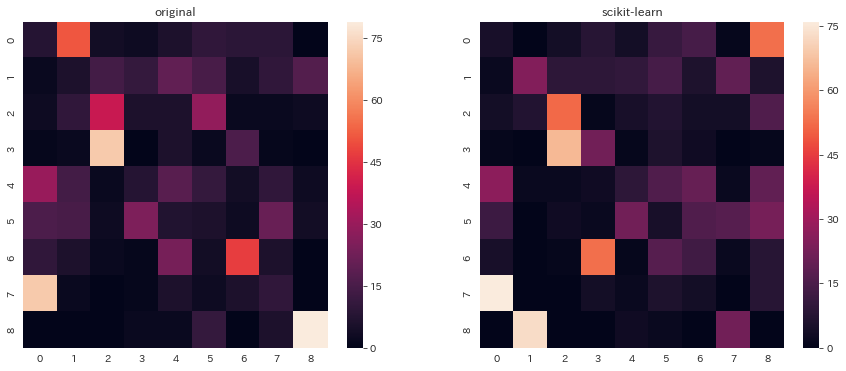

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.heatmap(news_cluster1, ax=axes[0])
sns.heatmap(news_cluster, ax=axes[1])
axes[0].set_title('original')
axes[1].set_title('scikit-learn')
plt.show()

列の順序が異なるものの、概ね同じ結果になりました。  

最後に、originalで最適化した場合でのトピックの所属確率が高い単語をいくつか見てみましょう

In [88]:
for i in range(9):
    top_word_idx = V1[:,i].argsort()[::-1][:20]
    print("topic {}".format(i))
    print(" ".join([vocab.index2word[w] for w in top_word_idx]))

topic 0
0歳 ぬ 今 くれる 仕事 私 いい 方 何 かも そんな さ 気 聞く 男性 し どう 持つ 考える 感じる
topic 1
日本 公開 ぬ 登場 紹介 知る 世界 について 何 0位 そして 大 人気 以上 特集 & おる 第 持つ 今
topic 2
関連 情報 声 twitter な てる 日本 ネット掲示板 おる ユーザー 氏 いい 発表 チェック どう 今 意見 問題 コメント 対応
topic 3
場合 について 方 くださる 必要 ※ 利用 名 上 おる 情報 ぬ 数 いただく プレゼント 方法 とき 発表 様 本
topic 4
行う について てる ぬ 利用 くれる 情報 前 による おる 行く 0月 可能 サービス 公開 対応 必要 発表 日本 語る
topic 5
さ 発表 発売 名 対応 約 0月 搭載 持つ 登場 関連 大 方 数 さらに プレゼント 予定 モデル smartphone ×
topic 6
てる けど な について いい し やる じゃ とか 何 日本 氏 方 どう 語る 持つ ところ 0歳 気 私
topic 7
そんな 紹介 名 アプリ いい 以上 てる 人気 持つ 0円 方 上 さ とき さらに ながら チェック ※ android 登場
topic 8
twitter smartphone 対応 max 利用 アプリ 画面 エスマックス 搭載 表示 サービス 関連リンク 場合 android 可能 紹介 on 設定 執筆 情報


いい感じにトピック抽出が出来ています。

# まとめ

* 行列分解はトピック抽出に使用できる
* newton法とは未知の関数を2次近似して逐次的に極小点を求めるアルゴリズム
* 文章×単語で単純な出現回数を数え合わせるより、単語毎の出現割合を値として使用した方がいい感じに分類できる